In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import os
import sys
from tensorboard.backend.event_processing import event_accumulator # For reading TensorBoard logs
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
try:
    project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
    if project_root not in sys.path:
        sys.path.insert(0, project_root)
    from src.utils import load_config, setup_logging, get_device
    from src.models import get_models
    from src.data_loader import get_data_loaders
except ImportError as e:
    print(f"ImportError: {e}")
    print("Make sure your notebook is in the 'notebooks' directory of the project,")
    print("and that 'src' is a Python package (contains __init__.py) and accessible.")
    print(f"Current sys.path: {sys.path}")
    print(f"Attempted project_root: {project_root}")
    raise

#### Configuration

In [3]:
setup_logging(log_to_console=True, log_file=None)

# IMPORTANT: Update these paths to point to your specific experiment results
EXPERIMENT_NAME = "colored_mnist_adagrad" # Change this to your actual experiment name
CONFIG_FILE_PATH = os.path.join(project_root, "configs", "colored_mnist_adagrad.yaml") # Or the config used for the experiment
RESULTS_BASE_DIR = os.path.join(project_root, "results")
EXPERIMENT_DIR = os.path.join(RESULTS_BASE_DIR, EXPERIMENT_NAME)
TENSORBOARD_LOG_DIR = os.path.join(EXPERIMENT_DIR, "tensorboard_logs")
CHECKPOINTS_DIR = os.path.join(EXPERIMENT_DIR, "checkpoints")
BEST_MODEL_PATH = os.path.join(CHECKPOINTS_DIR, "best_model.pth") # Or specific checkpoint

if not os.path.exists(EXPERIMENT_DIR):
    print(f"ERROR: Experiment directory not found: {EXPERIMENT_DIR}")
    print("Please ensure you have run training and specified the correct EXPERIMENT_NAME.")
    # Stop execution or handle gracefully
    raise FileNotFoundError(f"Experiment directory missing: {EXPERIMENT_DIR}")

config = load_config(CONFIG_FILE_PATH)
device = get_device(config['training'].get('device', 'cpu'))

2025-05-18 15:10:54 - root - INFO - Logging configured.
2025-05-18 15:10:54 - root - INFO - Successfully loaded configuration from: /home/asoliman/Projects/learning-not-to-learn/configs/colored_mnist_adagrad.yaml
2025-05-18 15:10:54 - root - INFO - Using device: cuda


In [4]:
# --- 1. Load Metrics from TensorBoard Logs ---
print(f"\n--- 1. Loading Metrics from TensorBoard Logs: {TENSORBOARD_LOG_DIR} ---")

def load_tensorboard_metrics(log_dir):
    """Loads scalar metrics from TensorBoard event files."""
    ea = event_accumulator.EventAccumulator(log_dir,
        size_guidance={ # See EA docs for more options
            event_accumulator.SCALARS: 0, # 0 = load all
        })
    ea.Reload() # Load all data from events files
    
    metrics = {}
    tags = ea.Tags()['scalars']
    for tag in tags:
        events = ea.Scalars(tag)
        metrics[tag] = pd.DataFrame([(event.step, event.value) for event in events],
                                    columns=['step', 'value'])
    if not metrics:
        print(f"No scalar metrics found in {log_dir}. Ensure TensorBoard logging was enabled and training ran.")
    return metrics

tb_metrics = {}
if os.path.exists(TENSORBOARD_LOG_DIR) and len(os.listdir(TENSORBOARD_LOG_DIR)) > 0 :
    tb_metrics = load_tensorboard_metrics(TENSORBOARD_LOG_DIR)
    print(f"Available metrics from TensorBoard: {list(tb_metrics.keys())}")
else:
    print(f"TensorBoard log directory is empty or does not exist: {TENSORBOARD_LOG_DIR}")
    print("Skipping TensorBoard metrics loading.")

2025-05-18 15:10:54.806433: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-18 15:10:54.814270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 15:10:54.824127: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-18 15:10:54.827280: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 15:10:54.835520: I tensorflow/core/platform/cpu_feature_guar


--- 1. Loading Metrics from TensorBoard Logs: /home/asoliman/Projects/learning-not-to-learn/results/colored_mnist_adagrad/tensorboard_logs ---


2025-05-18 15:10:55 - tensorboard - INFO - No path found after /home/asoliman/Projects/learning-not-to-learn/results/colored_mnist_adagrad/tensorboard_logs/events.out.tfevents.1747565396.asoliman-ASUS-TUF-Dash-F15.174093.0


Available metrics from TensorBoard: ['Train/loss_g', 'Train/loss_h_direct', 'Train/loss_adv_for_f', 'Train/total_loss_fg', 'Train/accuracy_g', 'Train/accuracy_h_direct', 'Train/accuracy_h_adv', 'Validation/loss_g', 'Validation/accuracy_g', 'Validation/loss_h', 'Validation/accuracy_h', 'LR/optimizer_fg']



--- 2. Plotting Learning Curves ---


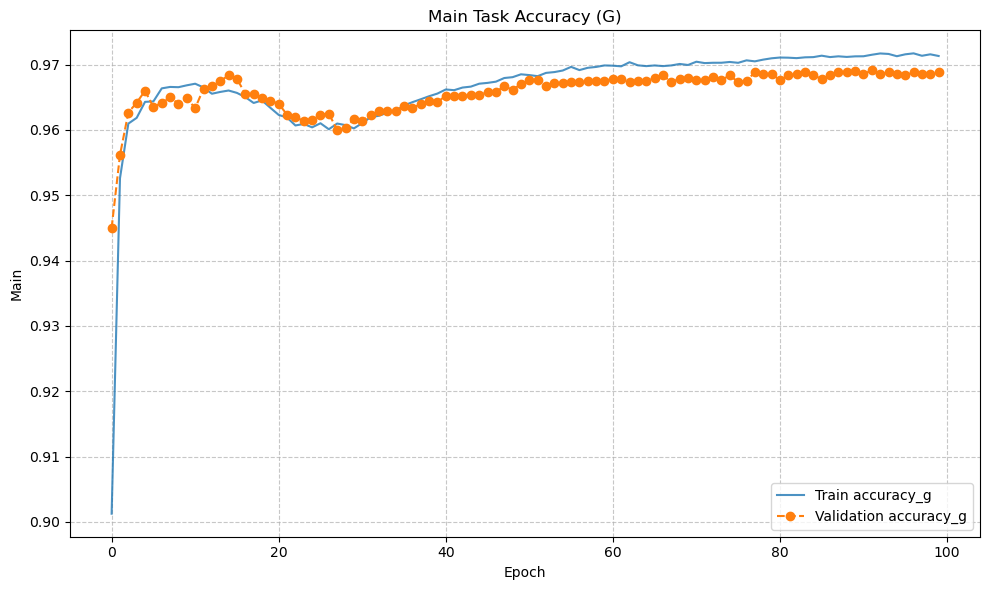

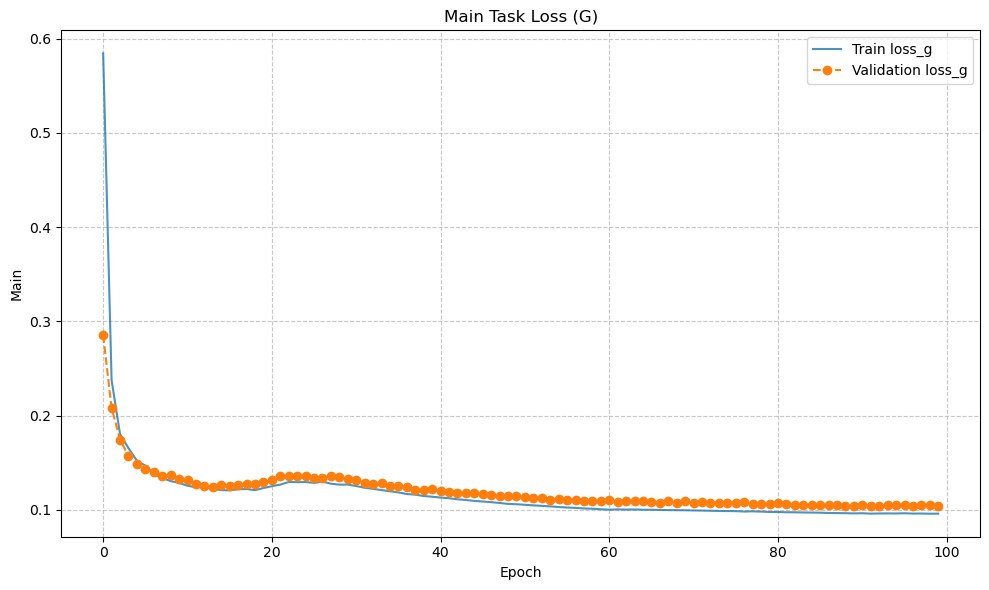

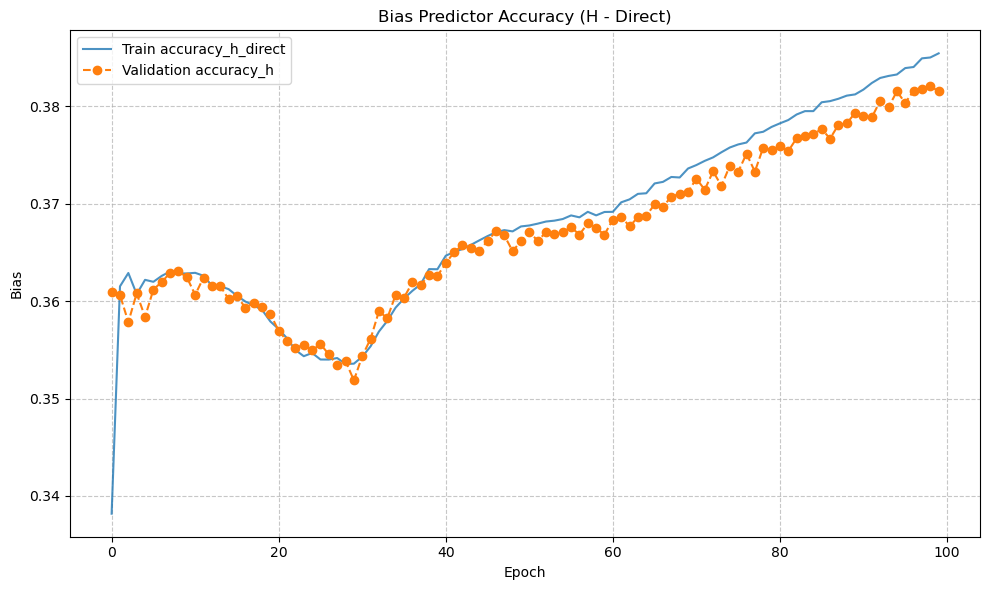

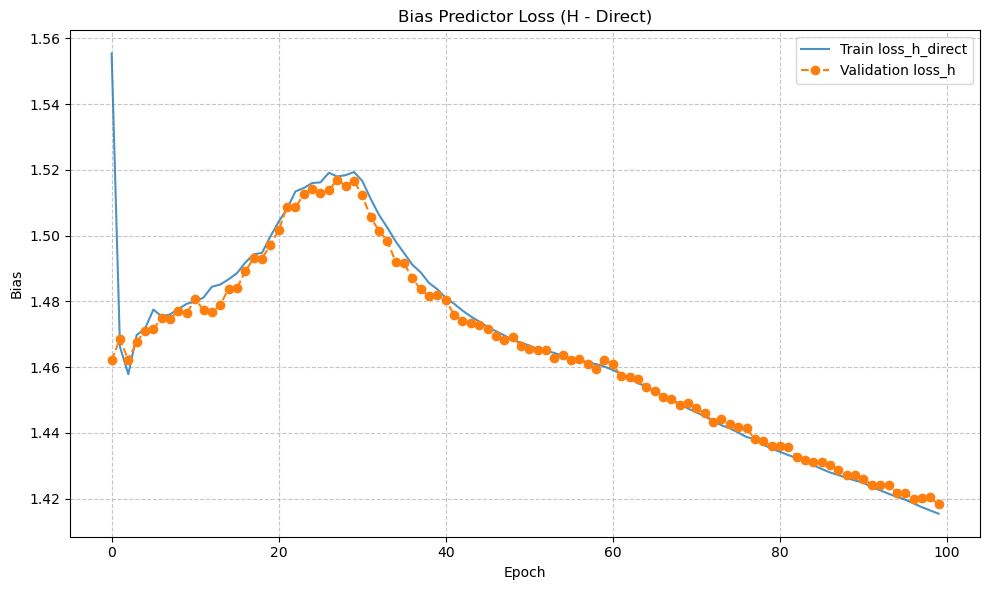

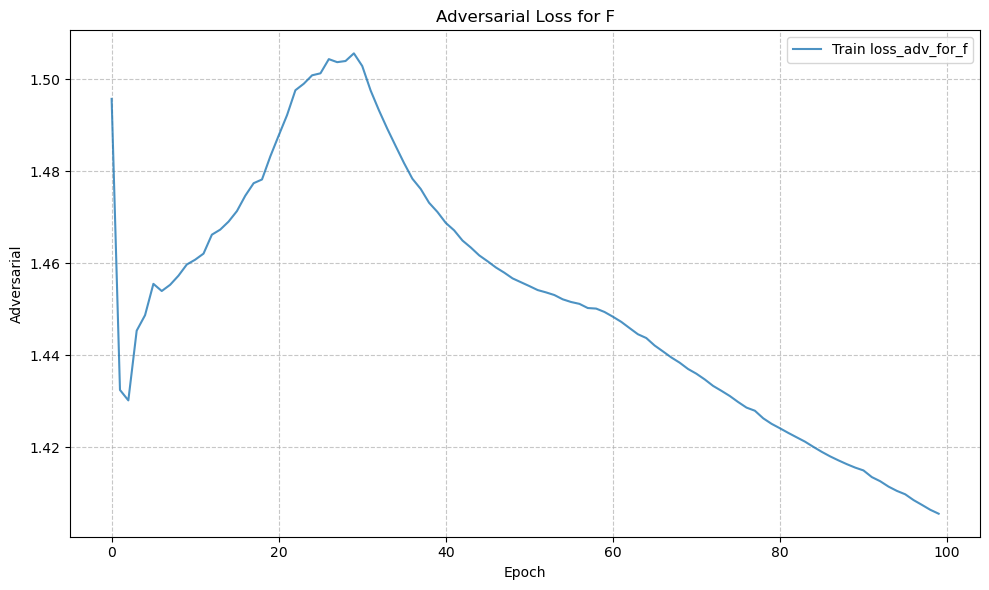

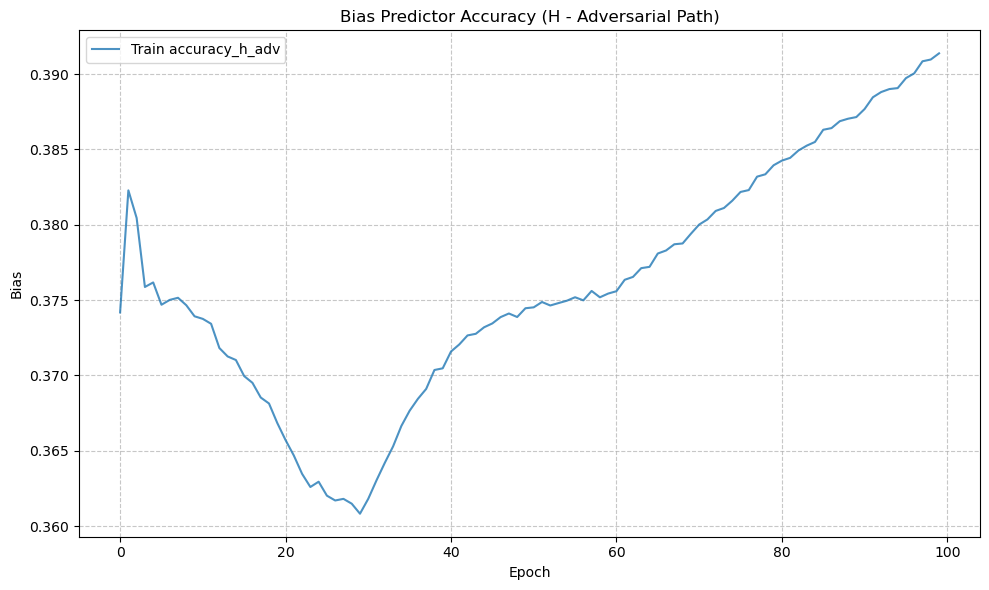

In [5]:
# --- 2. Plot Learning Curves ---
print("\n--- 2. Plotting Learning Curves ---")

def plot_metric(metrics_df_dict, primary_metric_key, val_metric_key=None, title="Metric over Epochs", ax=None):
    """Plots a training metric and its corresponding validation metric."""
    show_plot_later = False
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        show_plot_later = True

    if primary_metric_key in metrics_df_dict:
        df_train = metrics_df_dict[primary_metric_key]
        ax.plot(df_train['step'], df_train['value'], label=f'Train {primary_metric_key.split("/")[-1]}', alpha=0.8)
    else:
        print(f"Warning: Metric '{primary_metric_key}' not found in loaded TensorBoard metrics.")

    if val_metric_key and val_metric_key in metrics_df_dict:
        df_val = metrics_df_dict[val_metric_key]
        ax.plot(df_val['step'], df_val['value'], label=f'Validation {val_metric_key.split("/")[-1]}', marker='o', linestyle='--')
    elif val_metric_key:
        print(f"Warning: Metric '{val_metric_key}' not found for validation.")
        
    ax.set_xlabel("Epoch")
    ax.set_ylabel(title.split(' ')[0]) # Use first word of title as y-label
    ax.set_title(title)
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    if show_plot_later:
        plt.tight_layout()
        plt.show()

if tb_metrics:
    # Plot Main Task Accuracy
    plot_metric(tb_metrics, 'Train/accuracy_g', 'Validation/accuracy_g', 'Main Task Accuracy (G)')
    
    # Plot Main Task Loss
    plot_metric(tb_metrics, 'Train/loss_g', 'Validation/loss_g', 'Main Task Loss (G)')

    # Plot Bias Predictor (H) Direct Accuracy
    plot_metric(tb_metrics, 'Train/accuracy_h_direct', 'Validation/accuracy_h', 'Bias Predictor Accuracy (H - Direct)')
    
    # Plot Bias Predictor (H) Direct Loss
    plot_metric(tb_metrics, 'Train/loss_h_direct', 'Validation/loss_h', 'Bias Predictor Loss (H - Direct)')

    # Plot Adversarial Loss for F
    if 'Train/loss_adv_for_f' in tb_metrics:
         plot_metric(tb_metrics, 'Train/loss_adv_for_f', title='Adversarial Loss for F')
    
    # Plot Accuracy of H on GRL features (how well F is fooling H)
    if 'Train/accuracy_h_adv' in tb_metrics:
        plot_metric(tb_metrics, 'Train/accuracy_h_adv', title='Bias Predictor Accuracy (H - Adversarial Path)')
else:
    print("Skipping plotting learning curves as no TensorBoard metrics were loaded.")

2025-05-18 15:10:56 - root - INFO - LeNet_F initialized: Input Channels=3, Feature Dim=128
2025-05-18 15:10:56 - root - INFO - MLP_Classifier_G initialized: Input Dim=128, Hidden Dims=[64], Output Dim=10
2025-05-18 15:10:56 - root - INFO - ConvBiasPredictorH initialized: InputFeatureDim=128, NumBiasChannels=3, NumBiasQuantizationBins=8, Output Spatial=(14,14), IntermediateChannels=64, BaseSpatialDimForUpsample=7
2025-05-18 15:10:56 - root - INFO - All models created and moved to device.
2025-05-18 15:10:56 - root - INFO - LeNet_F initialized: Input Channels=3, Feature Dim=128
2025-05-18 15:10:56 - root - INFO - MLP_Classifier_G initialized: Input Dim=128, Hidden Dims=[64], Output Dim=10
2025-05-18 15:10:56 - root - INFO - ConvBiasPredictorH initialized: InputFeatureDim=128, NumBiasChannels=3, NumBiasQuantizationBins=8, Output Spatial=(14,14), IntermediateChannels=64, BaseSpatialDimForUpsample=7
2025-05-18 15:10:56 - root - INFO - All models created and moved to device.
2025-05-18 15:10


--- 3. Load Best Model and Evaluate (Example) ---
Loading best model from: /home/asoliman/Projects/learning-not-to-learn/results/colored_mnist_adagrad/checkpoints/best_model.pth
NOTEBOOK (Evaluation Cell): Updated eval_config['data']['path'] to absolute: /home/asoliman/Projects/learning-not-to-learn/data/colored_mnist
Model loaded successfully for evaluation.


2025-05-18 15:10:56 - root - INFO - Loaded train dataset: 60000 samples.
2025-05-18 15:10:56 - root - INFO - Loading data from: /home/asoliman/Projects/learning-not-to-learn/data/colored_mnist/mnist_10color_jitter_var_0.030.npy
2025-05-18 15:10:56 - root - INFO - Loaded test dataset: 10000 samples.
2025-05-18 15:10:56 - root - INFO - Train DataLoader: 60000 samples, Batch size: 128
2025-05-18 15:10:56 - root - INFO - Test DataLoader: 10000 samples, Batch size: 256


Running model on test set to collect predictions...

--- 4. Confusion Matrix for Main Task (on Test Set) ---


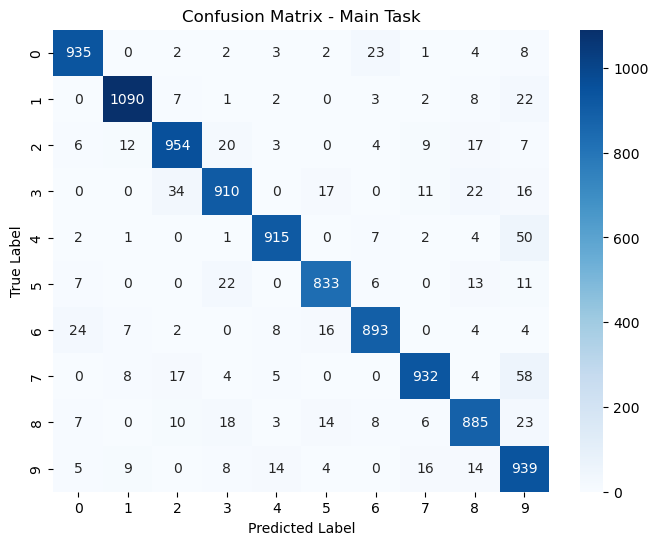

Overall Test Accuracy (from collected predictions): 0.9286


In [6]:
# --- 3. Load Model and Evaluate on Test Set (Example) ---
# This section shows how to load the best model and get predictions for further analysis.
print("\n--- 3. Load Best Model and Evaluate (Example) ---")

if not os.path.exists(BEST_MODEL_PATH):
    print(f"Best model checkpoint not found at: {BEST_MODEL_PATH}")
    print("Skipping model loading and detailed evaluation.")
else:
    print(f"Loading best model from: {BEST_MODEL_PATH}")
    models_dict_eval = get_models(config, device) # Re-initialize model structures
    
    # Create a deep copy of the config for this section to avoid modifying the global one
    eval_config = type(config)(config) # Creates a shallow copy for dicts; use copy.deepcopy for true isolation if needed

    if 'data' in eval_config and 'path' in eval_config['data']:
        if not os.path.isabs(eval_config['data']['path']):
            absolute_data_path = os.path.join(project_root, eval_config['data']['path'])
            eval_config['data']['path'] = os.path.abspath(absolute_data_path)
            print(f"NOTEBOOK (Evaluation Cell): Updated eval_config['data']['path'] to absolute: {eval_config['data']['path']}")
    else:
        print("WARNING (Evaluation Cell): 'data' or 'data.path' not found in eval_config.")

    models_dict_eval = get_models(eval_config, device) # Re-initialize model structures
    
    try:
        checkpoint = torch.load(BEST_MODEL_PATH, map_location=device)
        models_dict_eval['feature_extractor_f'].load_state_dict(checkpoint['feature_extractor_f_state_dict'])
        models_dict_eval['task_classifier_g'].load_state_dict(checkpoint['task_classifier_g_state_dict'])
        # models_dict_eval['bias_predictor_h'].load_state_dict(checkpoint['bias_predictor_h_state_dict']) # Optional for this part
        
        f_net_eval = models_dict_eval['feature_extractor_f'].eval()
        g_net_eval = models_dict_eval['task_classifier_g'].eval()
        
        print("Model loaded successfully for evaluation.")

        # Get Test DataLoader
        # Ensure create_val_loader is False if you only want the original test set
        # Or adjust get_data_loaders to always return a test_loader regardless of val split logic for train
        _, test_loader, _ = get_data_loaders(config, create_val_loader=False) 

        all_main_labels = []
        all_main_preds = []
        # all_bias_targets = [] # If you want to analyze bias predictions
        # all_bias_preds_map = []

        print("Running model on test set to collect predictions...")
        with torch.no_grad():
            for images, bias_targets_batch, main_labels_batch in test_loader:
                images = images.to(device)
                main_labels_batch = main_labels_batch.to(device)
                # bias_targets_batch = bias_targets_batch.to(device)

                features = f_net_eval(images)
                task_outputs = g_net_eval(features)
                _, main_preds_batch = torch.max(task_outputs, 1)
                
                all_main_labels.extend(main_labels_batch.cpu().numpy())
                all_main_preds.extend(main_preds_batch.cpu().numpy())

                # bias_preds_h = models_dict_eval['bias_predictor_h'](features)
                # _, bias_preds_map_batch = torch.max(bias_preds_h, dim=1) # (B, C, H, W)
                # all_bias_targets.extend(bias_targets_batch.cpu().numpy())
                # all_bias_preds_map.extend(bias_preds_map_batch.cpu().numpy())
        
        all_main_labels = np.array(all_main_labels)
        all_main_preds = np.array(all_main_preds)

        # --- 4. Confusion Matrix for Main Task ---
        print("\n--- 4. Confusion Matrix for Main Task (on Test Set) ---")
        if len(all_main_labels) > 0:
            cm = confusion_matrix(all_main_labels, all_main_preds)
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=range(config['data']['num_main_classes']), 
                        yticklabels=range(config['data']['num_main_classes']))
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title('Confusion Matrix - Main Task')
            plt.show()
            
            test_accuracy = np.mean(all_main_labels == all_main_preds)
            print(f"Overall Test Accuracy (from collected predictions): {test_accuracy:.4f}")
        else:
            print("No predictions collected to generate confusion matrix.")
            
    except FileNotFoundError:
        print(f"Could not load checkpoint for evaluation: {BEST_MODEL_PATH}")
    except Exception as e:
        print(f"An error occurred during model loading or evaluation: {e}")

In [7]:
# --- 5. Further Analysis (Placeholders) ---
print("\n--- 5. Further Analysis Ideas (Placeholders) ---")
print("- Analyze performance on bias-conflicting vs. bias-aligned samples (requires dataset to be structured for this).")
print("- Visualize features from f_net (e.g., using t-SNE) colored by main label and by bias label.")
print("- Examine misclassifications: what kind of samples are hard for the debiased model?")
print("- If bias is image-level (not pixel-wise), compare accuracy of H on test set.")


--- 5. Further Analysis Ideas (Placeholders) ---
- Analyze performance on bias-conflicting vs. bias-aligned samples (requires dataset to be structured for this).
- Visualize features from f_net (e.g., using t-SNE) colored by main label and by bias label.
- Examine misclassifications: what kind of samples are hard for the debiased model?
- If bias is image-level (not pixel-wise), compare accuracy of H on test set.
